# Adding OpenVINO GPU operator to support PP-OCRv4_det model 

## 1. Installing OpenVINO

In [1]:
!pip install openvino

## 2. Download prediction model

In [2]:
!wget https://paddleocr.bj.bcebos.com/PP-OCRv4/chinese/ch_PP-OCRv4_det_infer.tar && tar -xf ch_PP-OCRv4_det_infer.tar 

--2024-01-05 14:41:36--  https://paddleocr.bj.bcebos.com/PP-OCRv4/chinese/ch_PP-OCRv4_det_infer.tar
Resolving paddleocr.bj.bcebos.com (paddleocr.bj.bcebos.com)... 111.63.96.3
Connecting to paddleocr.bj.bcebos.com (paddleocr.bj.bcebos.com)|111.63.96.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4894720 (4.7M) [application/x-tar]
Saving to: 'ch_PP-OCRv4_det_infer.tar'

     0K .......... .......... .......... .......... ..........  1%  277K 17s
    50K .......... .......... .......... .......... ..........  2%  338K 15s
   100K .......... .......... .......... .......... ..........  3%  447K 14s
   150K .......... .......... .......... .......... ..........  4%  442K 13s
   200K .......... .......... .......... .......... ..........  5%  539K 12s
   250K .......... .......... .......... .......... ..........  6%  662K 11s
   300K .......... .......... .......... .......... ..........  7%  661K 10s
   350K .......... .......... .......... .......... .........

## 3. Define relevant codes

In [1]:
import cv2 as cv
import openvino as ov
import numpy as np
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt

In [3]:
def preprocess_image(img0: np.ndarray):
    # resize
    img = cv.resize(img0, (960,960), interpolation=cv.INTER_LINEAR)
    
    # Convert HWC to CHW
    
    img = np.ascontiguousarray(img)
    input_tensor = img.astype(np.float32)  # uint8 to fp32
    input_tensor /= 255.0  # 0 - 255 to 0.0 - 1.0
    mean = np.array((0.485, 0.456, 0.406))[np.newaxis, np.newaxis, :]
    std = np.array((0.229, 0.224, 0.225))[np.newaxis, np.newaxis, :]
    input_tensor -= mean
    input_tensor /= std
    input_tensor = input_tensor.transpose(2, 0, 1)
    # add batch dimension
    if input_tensor.ndim == 3:
        input_tensor = np.expand_dims(input_tensor, 0)
    return input_tensor

## 4. Using CPU inference

In [4]:
det_model_path = '.\ch_PP-OCRv4_det_infer\inference.pdmodel'
device = "CPU"

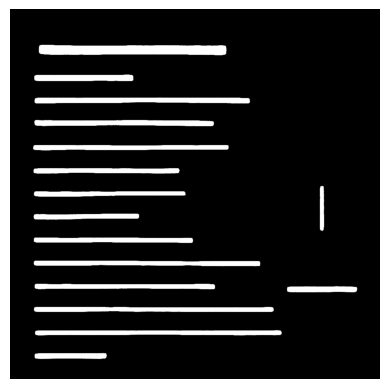

In [5]:
core = ov.Core()
ov_model = core.read_model(det_model_path)
compiled_model = core.compile_model(ov_model, device)
image = np.array(Image.open('demo_1.jpg'))
input_tensor = preprocess_image(image)
result = compiled_model(input_tensor)
result_image = result['sigmoid_0.tmp_0'].reshape(960,960)

gray_image = cv.cvtColor(np.uint8(result_image*255), cv.COLOR_GRAY2BGR)
image_ = Image.fromarray(gray_image)
plt.imshow(image_)
plt.axis('off') # 隐藏坐标轴
plt.show()

## 5. Using GPU inference

In [7]:
device = "GPU.0"

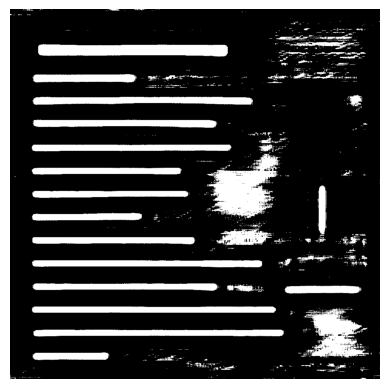

In [75]:
core = ov.Core()
ov_model = core.read_model(det_model_path)
compiled_model = core.compile_model(ov_model, device)
image = np.array(Image.open('demo_1.jpg'))
input_tensor = preprocess_image(image)
result = compiled_model(input_tensor)
result_image = result['sigmoid_0.tmp_0'].reshape(960,960)

gray_image = cv.cvtColor(np.uint8(result_image*255), cv.COLOR_GRAY2BGR)
image_ = Image.fromarray(gray_image)
plt.imshow(image_)
plt.axis('off') # 隐藏坐标轴
plt.show()

Comparing the output images of CPU and GPU, it can be seen that the GPU output results not only contain the content of the text area, but also have false detections in other areas, which brings great trouble to the subsequent extraction of the text area.